In [15]:
# Essential and common packages
import os
import glob

# Read and visualize the raster data
import rasterio
from rasterio.plot import show

# Plots and bars
import matplotlib.pyplot as plt
import seaborn as sns

# Computation library
import numpy as np

# Tensorflow for building the resnet50 model
import tensorflow.python.keras as k
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.initializers import random_uniform, glorot_uniform
from tensorflow.keras.models import Model

# Sklearn for confusion matrix
import itertools
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

# For visualization of plots without plt.show()
%matplotlib inline


ImportError: cannot import name 'plot_confusion_matrix' from 'sklearn.metrics' (C:\Users\Eka Wariah\anaconda3\Lib\site-packages\sklearn\metrics\__init__.py)

In [16]:
pip install --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [20]:
# Essential and common packages
import os
import glob

# Read and visualize the raster data
import rasterio
from rasterio.plot import show

# Plots and bars
import matplotlib.pyplot as plt
import seaborn as sns

# Computation library
import numpy as np

# Tensorflow for building the resnet50 model
import tensorflow.python.keras as k
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.initializers import random_uniform, glorot_uniform
from tensorflow.keras.models import Model

# Sklearn for confusion matrix
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# For visualization of plots without plt.show()
%matplotlib inline


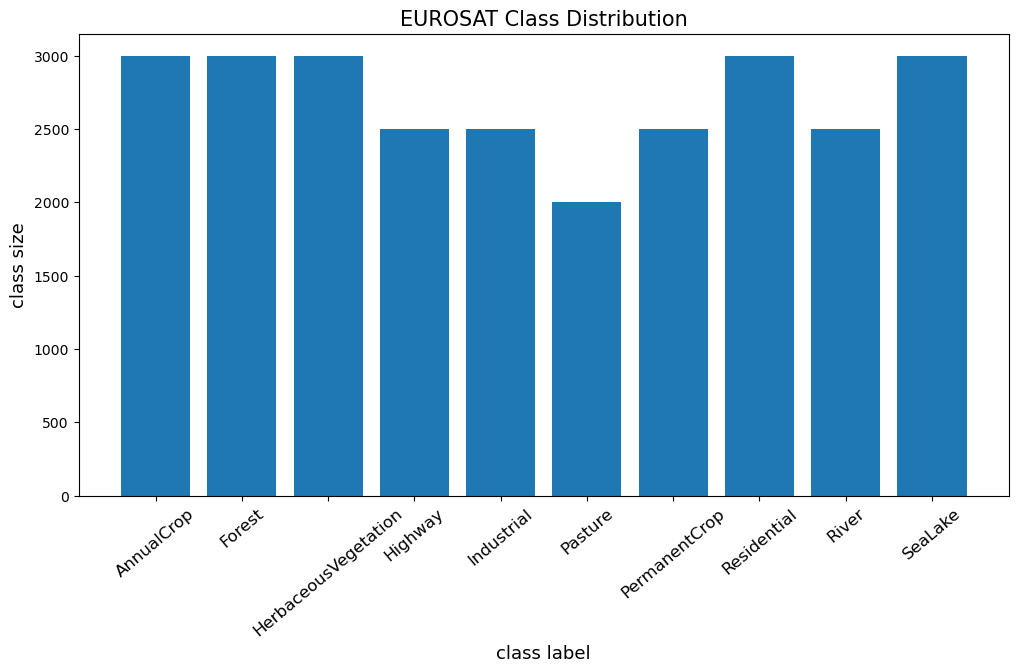

In [28]:
# plot class distributions of whole dataset
counts = {}

for l in LABELS:
    counts[l] = len(os.listdir(os.path.join(DATASET, l)))


plt.figure(figsize=(12, 6))

plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.xticks(range(len(counts)), list(counts.keys()), fontsize=12, rotation=40)
plt.xlabel('class label', fontsize=13)
plt.ylabel('class size', fontsize=13)
plt.title('EUROSAT Class Distribution', fontsize=15);

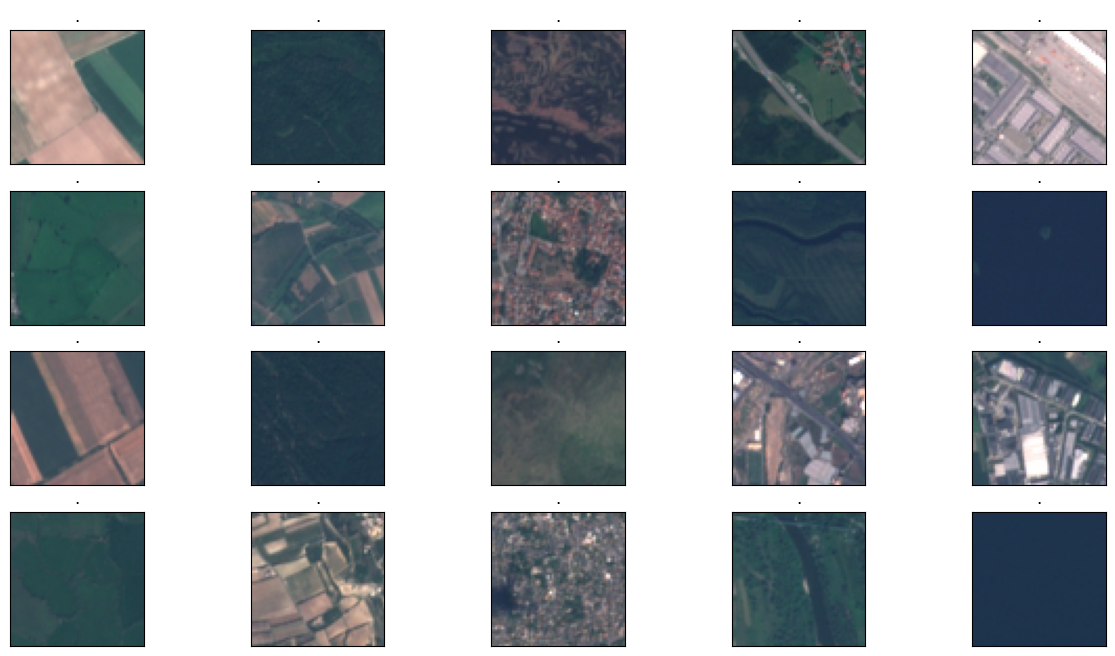

In [29]:
import PIL
img_paths = [os.path.join(DATASET, l, l+'_1000.jpg') for l in LABELS]

img_paths = img_paths + [os.path.join(DATASET, l, l+'_2000.jpg') for l in LABELS]

def plot_sat_imgs(paths):
    plt.figure(figsize=(15, 8))
    for i in range(20):
        plt.subplot(4, 5, i+1, xticks=[], yticks=[])
        img = PIL.Image.open(paths[i], 'r')
        plt.imshow(np.asarray(img))
        plt.title(paths[i].split('/')[-2])

plot_sat_imgs(img_paths)

In [31]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=validation_split, rescale=rescale)
dataset = tf.keras.preprocessing.image_dataset_from_directory(DATASET, image_size=(img_height, img_width), batch_size=batch_size)

Found 27000 files belonging to 10 classes.


In [33]:
train_dataset = datagen.flow_from_directory(batch_size=batch_size,
                                           directory=DATASET,
                                           shuffle=True,
                                           target_size=(img_height, img_width),
                                           subset="training",
                                           class_mode='categorical')

Found 21600 images belonging to 10 classes.


In [34]:
test_dataset = datagen.flow_from_directory(batch_size=batch_size,
                                           directory=DATASET,
                                           shuffle=True,
                                           target_size=(img_height, img_width),
                                           subset="validation",
                                           class_mode='categorical')

Found 5400 images belonging to 10 classes.


In [35]:
def identity_block(X, f, filters, training=True, initializer=random_uniform):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value.
    X_shortcut = X
    cache = []
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X_shortcut, X])
    X = X = Activation('relu')(X, training = training)

    return X

In [37]:
def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    
    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    
    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides = (1, 1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3, (1, 1), strides = (s, s), padding = 'valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training = training)

    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [38]:
def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])
    
   # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size = (2, 2), name = 'avg_pool')(X)
    

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [39]:
model = ResNet50(input_shape=(64,64,3), classes=10)

In [40]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
history = model.fit(train_dataset, validation_data=test_dataset, epochs=20, batch_size=32)

Epoch 1/20


C:\Users\Eka Wariah\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


675/675 ━━━━━━━━━━━━━━━━━━━━ 725s 1s/step - accuracy: 0.4571 - loss: 1.8469 - val_accuracy: 0.3189 - val_loss: 3.3843
Epoch 2/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 1203s 2s/step - accuracy: 0.6809 - loss: 0.9443 - val_accuracy: 0.3730 - val_loss: 5.2829
Epoch 3/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 1165s 2s/step - accuracy: 0.7266 - loss: 0.8230 - val_accuracy: 0.5181 - val_loss: 1.9080
Epoch 4/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 1160s 2s/step - accuracy: 0.5521 - loss: 1.5178 - val_accuracy: 0.6507 - val_loss: 0.9977
Epoch 5/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 695s 1s/step - accuracy: 0.7160 - loss: 0.8126 - val_accuracy: 0.3470 - val_loss: 3.7823
Epoch 6/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 650s 963ms/step - accuracy: 0.7617 - loss: 0.7240 - val_accuracy: 0.6293 - val_loss: 2.1911
Epoch 7/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 579s 857ms/step - accuracy: 0.7905 - loss: 0.6699 - val_accuracy: 0.0904 - val_loss: 3022.4558
Epoch 8/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 563s 834ms/step - accuracy: 0.7359 - loss: 0.8290 - val_

In [48]:
model.save('./my_model.h5')

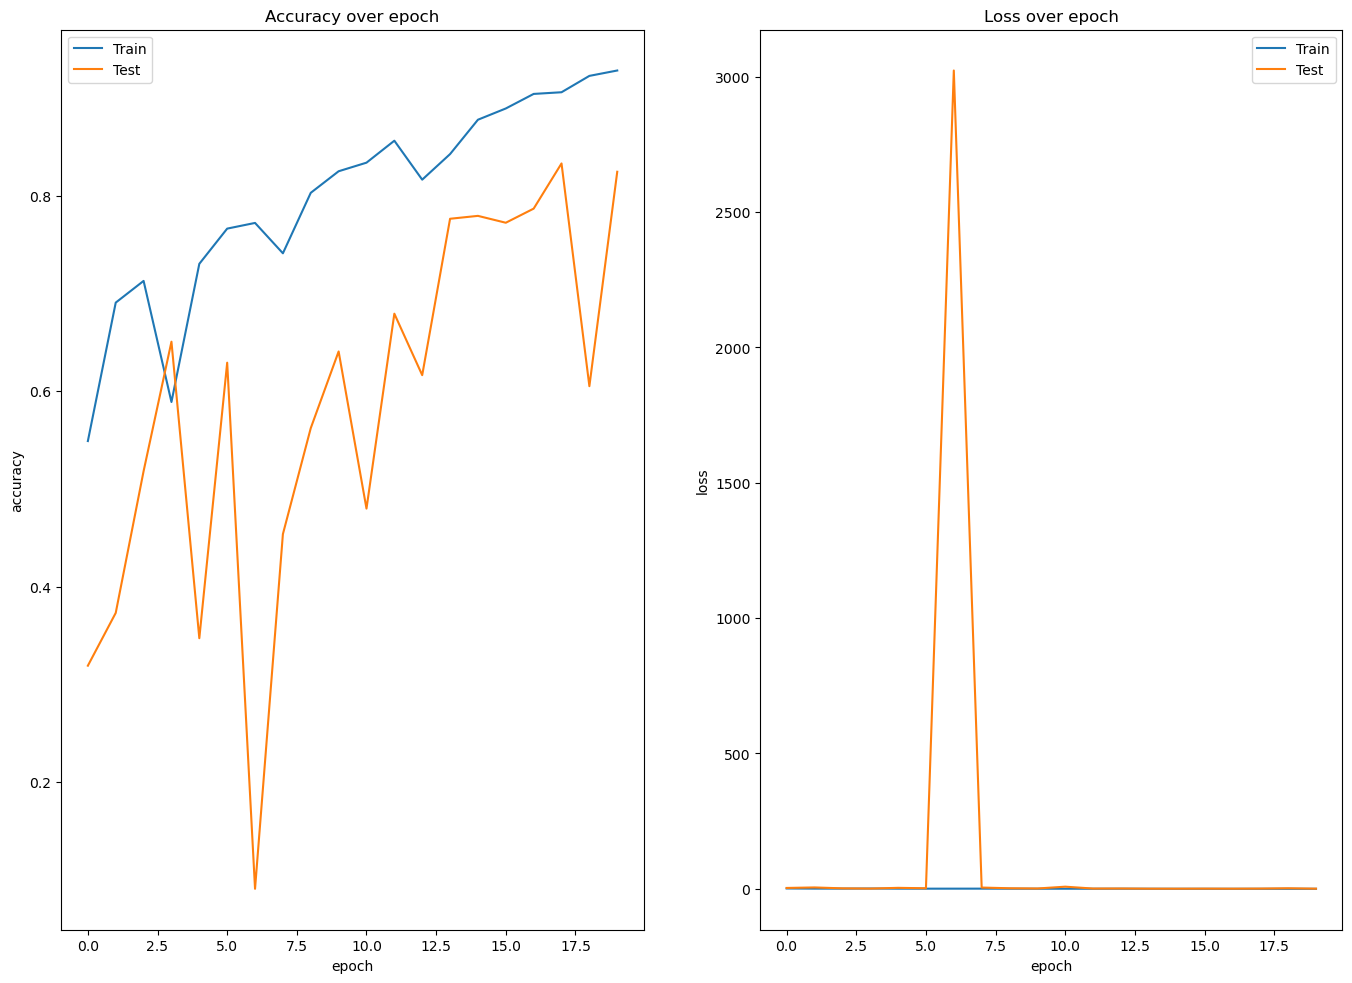

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16.53, 11.69))
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.set_title('Accuracy over epoch')
ax1.legend(['Train', 'Test'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
ax2.set_title('Loss over epoch')
ax2.legend(['Train', 'Test'], loc="upper right")

In [50]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for i, (image_batch, label_batch) in enumerate(test_dataset):   # use dataset.unbatch() with repeat
    # append true labels
    y_true.append(label_batch)
    # compute predictions
    preds = model.predict(image_batch)
    # append predicted labels
    y_pred.append(np.argmax(preds, axis =  1))
    if i==300:
        break

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
correct_labels = np.argmax(correct_labels, axis=1)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [51]:
cm = confusion_matrix(correct_labels, predicted_labels)
cm

array([[ 975,    6,    2,   10,    0,   25,   43,    0,   23,    8],
       [   4, 1009,    4,    1,    0,   28,   24,    1,    2,    0],
       [   0,    2,  861,    9,    3,    7,  169,    9,    0,    2],
       [  19,    2,   10,  725,   45,    4,   49,    8,   20,    0],
       [   0,    0,  136,    4,  718,    0,   10,    8,    1,    0],
       [  23,   10,   12,   10,    0,  502,  139,    0,   17,    0],
       [  39,    0,   36,   14,    1,    9,  780,    4,    6,    0],
       [   0,    0,   51,    7,   48,    0,   68,  912,    0,    0],
       [  30,    2,   22,  160,    6,   38,   53,    2,  554,    2],
       [  57,   52,   18,    0,    0,   17,    2,    0,    8,  927]],
      dtype=int64)

In [52]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        figsize=(10, 10),
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 975    6    2   10    0   25   43    0   23    8]
 [   4 1009    4    1    0   28   24    1    2    0]
 [   0    2  861    9    3    7  169    9    0    2]
 [  19    2   10  725   45    4   49    8   20    0]
 [   0    0  136    4  718    0   10    8    1    0]
 [  23   10   12   10    0  502  139    0   17    0]
 [  39    0   36   14    1    9  780    4    6    0]
 [   0    0   51    7   48    0   68  912    0    0]
 [  30    2   22  160    6   38   53    2  554    2]
 [  57   52   18    0    0   17    2    0    8  927]]


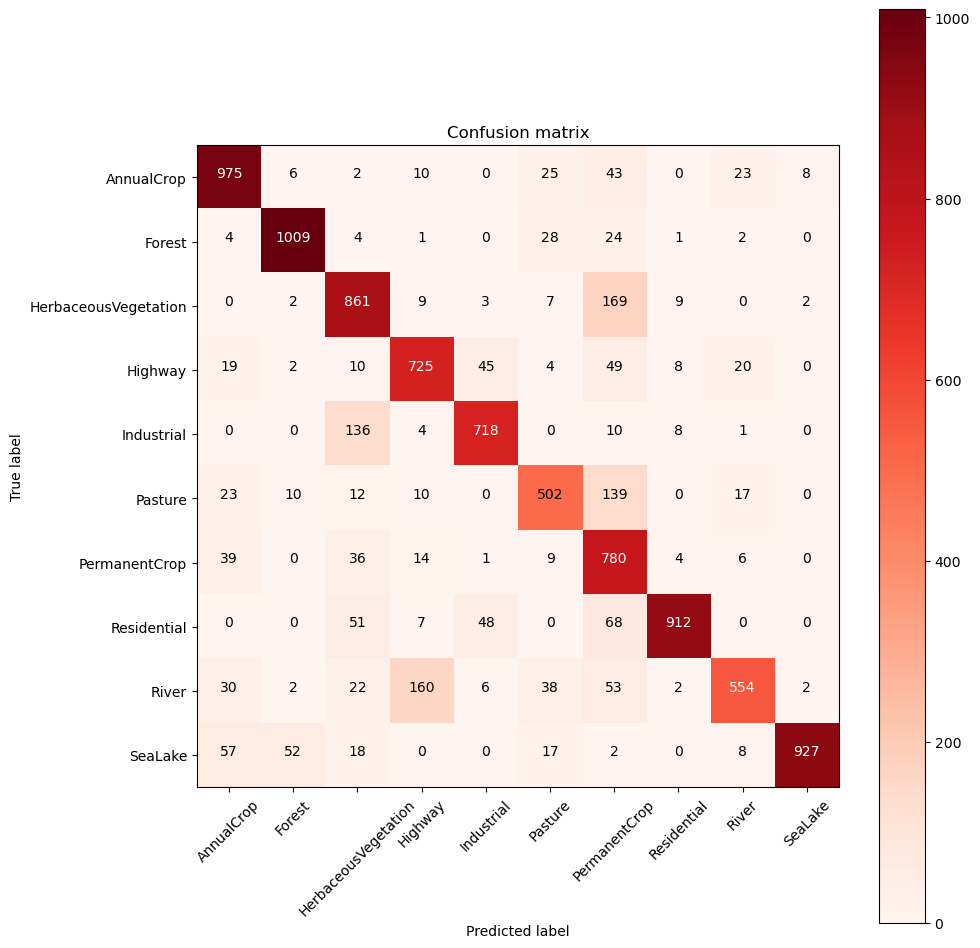

In [53]:
plot_confusion_matrix(cm, train_dataset.class_indices, cmap='Reds')

In [8]:
model = ResNet50(input_shape=(64,64,3), classes=10)

In [54]:
from tensorflow.keras.models import load_model
model = load_model(r"lulc")

ValueError: File format not supported: filepath=lulc. Keras 3 only supports V3 `.keras` files and legacy H5 format files (`.h5` extension). Note that the legacy SavedModel format is not supported by `load_model()` in Keras 3. In order to reload a TensorFlow SavedModel as an inference-only layer in Keras 3, use `keras.layers.TFSMLayer(lulc, call_endpoint='serving_default')` (note that your `call_endpoint` might have a different name).